<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/brist1d_blood_glucose_prediction_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrisT1D Blood Glucose Prediction with TabNet

In [16]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [17]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [19]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [20]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [21]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = df_train[colset].interpolate(axis=1)
    df_test[colset] = df_test[colset].interpolate(axis=1)

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [22]:
imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [23]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [24]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [25]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

## Training & Inference


In [26]:
X = df_train[feature_cols]
y = df_train[[target_col]]

In [27]:
# X.columns

# print(feature_cols)

In [28]:
X = df_train[feature_cols]
y = df_train[[target_col]]
groups = df_train[group_col]
cv = GroupKFold(5)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v0/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 6.71366 | val_0_rmse: 2.46271 |  0:00:07s
epoch 1  | loss: 4.20345 | val_0_rmse: 2.21681 |  0:00:15s
epoch 2  | loss: 4.12008 | val_0_rmse: 2.19414 |  0:00:23s
epoch 3  | loss: 4.06149 | val_0_rmse: 2.24039 |  0:00:30s
epoch 4  | loss: 4.00005 | val_0_rmse: 2.22172 |  0:00:38s
epoch 5  | loss: 3.98018 | val_0_rmse: 2.21863 |  0:00:45s
epoch 6  | loss: 3.95261 | val_0_rmse: 2.21443 |  0:00:53s
epoch 7  | loss: 3.9398  | val_0_rmse: 2.21545 |  0:01:00s
epoch 8  | loss: 3.92095 | val_0_rmse: 2.26076 |  0:01:08s
epoch 9  | loss: 3.93116 | val_0_rmse: 2.24404 |  0:01:15s
epoch 10 | loss: 3.88734 | val_0_rmse: 2.19808 |  0:01:23s
epoch 11 | loss: 3.88919 | val_0_rmse: 2.19886 |  0:01:31s
epoch 12 | loss: 3.86573 | val_0_rmse: 2.17336 |  0:01:38s
epoch 13 | loss: 3.92993 | val_0_rmse: 2.25636 |  0:01:46s
epoch 14 | loss: 3.91302 | val_0_rmse: 2.21101 |  0:01:53s
epoch 15 | loss: 3.90345 | val_0_rmse: 2.20184 |  0:02:01s
epoch 16 | loss: 3.89946 | val_0_rmse: 2.16929 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

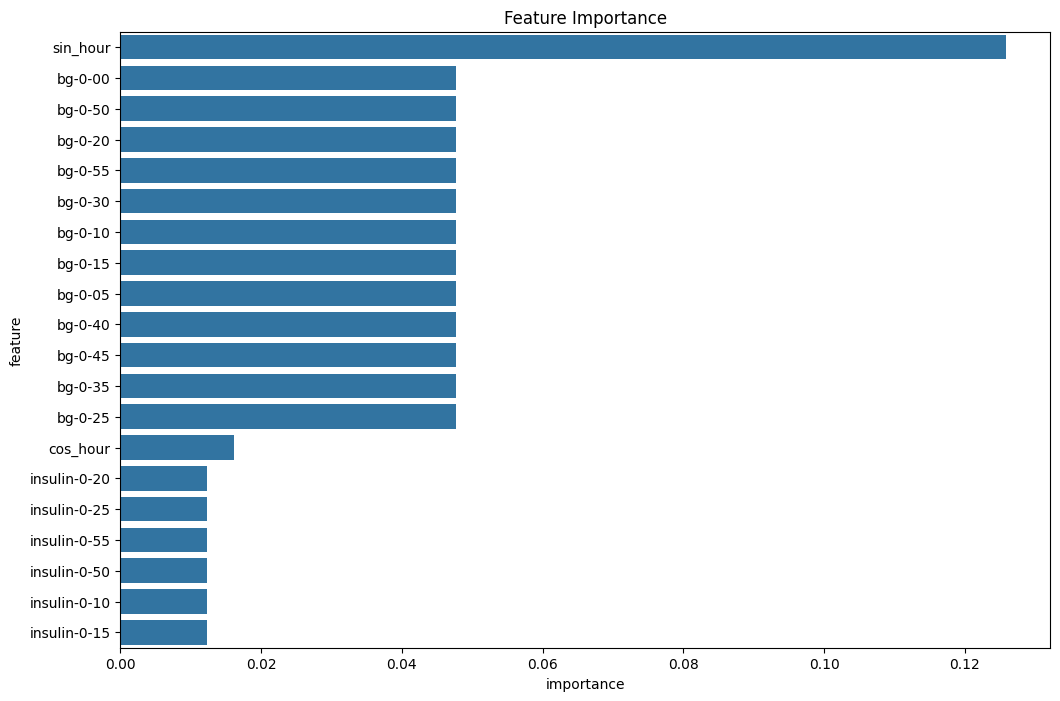

In [29]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [30]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.972011
p01_8460,5.830921
p01_8461,7.794858
p01_8462,10.844385
p01_8463,6.398709


In [31]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv')

In [32]:
oof_results.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN
p01_1,NaN,NaN,NaN,12.762192,NaN
p01_2,NaN,NaN,NaN,12.50032,NaN
p01_3,NaN,NaN,NaN,12.799201,NaN
p01_4,NaN,NaN,NaN,12.184162,NaN


In [33]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN,13.334588
p01_1,NaN,NaN,NaN,12.762192,NaN,12.762192
p01_2,NaN,NaN,NaN,12.50032,NaN,12.50032
p01_3,NaN,NaN,NaN,12.799201,NaN,12.799201
p01_4,NaN,NaN,NaN,12.184162,NaN,12.184162


In [34]:
oof_results.isna().sum()

,0
0,150996
1,142864
2,143187
3,143266
4,127783
average,0


In [35]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv")

# BrisT1D Blood Glucose Prediction with StackedRegressor

In [49]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [50]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = "bg+1-00"  # Target column name for prediction
group_col = "p_num"  # Column name for grouping (e.g., participant number)
date_col = "time"  # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols = [f"bg-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
insu_cols = [f"insulin-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
carb_cols = [f"carbs-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
hr_cols = [f"hr-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
step_cols = [f"steps-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
cals_cols = [f"cals-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [51]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [52]:
import random
import os
import numpy as np
import torch


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [53]:
seed = 43  #
Thr_NAN = 49
seed_everything(seed)

In [54]:
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(":", "-")
df_test.columns = df_test.columns.str.replace(":", "-")


for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )

In [57]:
mask = df_train[feature_cols].isna().sum(axis=1) <= Thr_NAN
# Apply the mask to filter the rows
df_train = df_train[mask]


imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])


df_train["sin_hour"] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train["cos_hour"] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test["sin_hour"] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test["cos_hour"] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(["sin_hour", "cos_hour"])


grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)


df_train_final = df_train[feature_cols]
groups = df_train[group_col]

y_target = df_train[[target_col]]

df_test_final = df_test[feature_cols]

In [58]:
df_train_final.columns

Index(['bg-0-00', 'bg-0-05', 'bg-0-10', 'bg-0-15', 'bg-0-20', 'bg-0-25',
       'bg-0-30', 'bg-0-35', 'bg-0-40', 'bg-0-45', 'bg-0-50', 'bg-0-55',
       'insulin-0-00', 'insulin-0-05', 'insulin-0-10', 'insulin-0-15',
       'insulin-0-20', 'insulin-0-25', 'insulin-0-30', 'insulin-0-35',
       'insulin-0-40', 'insulin-0-45', 'insulin-0-50', 'insulin-0-55',
       'carbs-0-00', 'carbs-0-05', 'carbs-0-10', 'carbs-0-15', 'carbs-0-20',
       'carbs-0-25', 'carbs-0-30', 'carbs-0-35', 'carbs-0-40', 'carbs-0-45',
       'carbs-0-50', 'carbs-0-55', 'hr-0-00', 'hr-0-05', 'hr-0-10', 'hr-0-15',
       'hr-0-20', 'hr-0-25', 'hr-0-30', 'hr-0-35', 'hr-0-40', 'hr-0-45',
       'hr-0-50', 'hr-0-55', 'steps-0-00', 'steps-0-05', 'steps-0-10',
       'steps-0-15', 'steps-0-20', 'steps-0-25', 'steps-0-30', 'steps-0-35',
       'steps-0-40', 'steps-0-45', 'steps-0-50', 'steps-0-55', 'cals-0-00',
       'cals-0-05', 'cals-0-10', 'cals-0-15', 'cals-0-20', 'cals-0-25',
       'cals-0-30', 'cals-0-35', 'cals-

## Train the Model:

In [79]:
%%capture
!pip install skops
!!pip install catboost

In [80]:
import skops.io as sio

In [81]:
df_subm_stack = df_subm.copy()

In [82]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

X_test = df_test_final.to_numpy()

groups = df_train[group_col]
cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v2_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8643085	total: 10.7s	remaining: 21.4s
1002:	learn: 1.8641442	total: 10.7s	remaining: 21.4s
1003:	learn: 1.8640122	total: 10.8s	remaining: 21.4s
1004:	learn: 1.8638137	total: 10.8s	remaining: 21.4s
1005:	learn: 1.8637006	total: 10.8s	remaining: 21.4s
1006:	learn: 1.8635742	total: 10.8s	remaining: 21.3s
1007:	learn: 1.8633916	total: 10.8s	remaining: 21.3s
1008:	learn: 1.8632438	total: 10.8s	remaining: 21.3s
1009:	learn: 1.8631322	total: 10.8s	remaining: 21.3s
1010:	learn: 1.8629973	total: 10.8s	remaining: 21.3s
1011:	learn: 1.8628029	total: 10.8s	remaining: 21.3s
1012:	learn: 1.8626712	total: 10.8s	remaining: 21.3s
1013:	learn: 1.8625340	total: 10.9s	remaining: 21.3s
1014:	learn: 1.8624135	total: 10.9s	remaining: 21.3s
1015:	learn: 1.8622388	total: 10.9s	remaining: 21.2s
1016:	learn: 1.8620770	total: 10.9s	remaining: 21.2s
1017:	learn: 1.8619116	total: 10.9s	remaining: 21.2s
1018:	learn: 1.8618258	total: 10.9s	remaining: 2

## Save Results:

In [83]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444


In [84]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv')

In [85]:
oof_results_stack.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN
p01_1,NaN,NaN,NaN,12.638141,NaN
p01_2,NaN,NaN,NaN,12.835038,NaN
p01_3,NaN,NaN,NaN,13.330393,NaN
p01_4,NaN,NaN,NaN,12.495023,NaN


In [86]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN,13.076592
p01_1,NaN,NaN,NaN,12.638141,NaN,12.638141
p01_2,NaN,NaN,NaN,12.835038,NaN,12.835038
p01_3,NaN,NaN,NaN,13.330393,NaN,13.330393
p01_4,NaN,NaN,NaN,12.495023,NaN,12.495023


In [87]:
oof_results_stack.isna().sum()

,0
0,149462
1,141441
2,141674
3,141732
4,127651
average,0


In [88]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v0.csv")

In [91]:
tab = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
stack = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv', index_col='id')

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444
...,...
p24_256,6.563980
p24_257,9.650507
p24_258,7.268640


In [94]:
ensemble_v0 = (tab+stack)/2

In [95]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v0.csv')